# Next steps for automated scoring WITH CLARASSISTANT
I need to change the system prompt in order to get the LLM's answer to adapt to my scoring instead of the other way around (so no .split().strip() because the format will be different from LLM to LLM).

I am taking too many "opinionated" decisions where I make a certain hypothesis, but we don't actually know whether it's true, so we need to measure against a baseline without those hypotheses (like 5% tolerance for example, could work, but could be terribly wrong...)

In [3]:
from clarassistant.llms.factory import LLMFactory
#from clarassistant.llms import LLMFactory
import os
from dotenv import load_dotenv

load_dotenv(dotenv_path = os.path.join("C:/Users", "p.beglin", ".env"))

True

In [7]:
import pandas as pd
target = pd.read_csv('target/target_digit_integer', sep=';')

In [9]:
# Optimal Prompts 2
examplePromptsO = """
User: Which country sold the most units?
Bot: France
## 
User: Can you rank the countries in descending order per turnover?
Bot: ['France', 'Spain', 'Italy']
## 
User: Do clients in France spend more than in Italy?
Bot: Yes
## 
"""

systemPromptO = f"""
You are a data analyst assistant programmed to provide concise and specific answers based on the data presented, without additional explanation or detail. Follow these guidelines for responding:
- For numeric values, provide integers whenever possible, or round to two decimal places using a period (.) for decimals.
- For list or ranking requests, format the answer as a Python-style list, e.g., ['France', 'Spain', 'Italy'].
- For yes/no questions, respond with 'Yes' or 'No' only.
- Assume all questions are data-driven and require precise, direct responses based on the provided data.
{examplePromptsO}
Here is the table:
###
"""

In [11]:
llm.messages

[]

In [17]:
# FINAL CELL
modelTestList = ['mistral-small', 'gpt3.5', 'command-r', 'claude-haiku']
modelTestList2 = ['mistral-small']

# Import TXT
directory = "data/multiTXT_integers/"
files = os.listdir(directory)

# Define the DataFrame to store LLM responses
LLMresponse_columns = ["Model", "Prompt"] + [f"Response {scenario}" for scenario in files]
LLMresponse = pd.DataFrame(columns=LLMresponse_columns)

#############################
for model in modelTestList: #only test currently
    print(model)
    for idx, prompt_row in target.iterrows():   # could also do: prompt = target.at[j, 'Prompt'] instead of iterrows() if i don't compare to target straight after
        #if idx == 1:  # Stop after processing the first prompt
        #    break
        prompt = prompt_row['Prompt']
        responses = [model, prompt]  # start each row with the prompt

        for fileName in files:
            with open(os.path.join(directory, fileName), 'r', encoding='utf-8') as file:
                loaded_string = file.read()         # est-ce que ça risque de fortement ralentir la boucle ? Comparé à avoir cette donnée en mémoire
            
            ##############
            factory = LLMFactory()
            llm = factory(model, system_prompt=systemPromptO + loaded_string) #temperature=0, response_size=50
            #print("SYSTEM PROMPT: ", systemPrompt+loaded_string)
            #print("XXXXXXXXXXXXXXXXXXXXXXXXXX")
            #print("PROMPT: ", prompt)
            
            # NOW Appending message history with examples...
            llm.messages.append({"user": "Can you rank the countries in descending order per turnover?", "bot": "['France', 'Spain', 'Italy']"})
            llm.messages.append({"user": "Do purchasers in Italy spend more than in France?", "bot": "Yes"})
            llm.messages.append({"user": "How many KPIs are there?", "bot": "4"})
            llm.messages.append({"user": "How many more clients are there in Italy compared to France", "bot": "-31"})
            llm.messages.append({"user": "What is the average number of articles each client buys", "bot": "12.90"})

            #########
            response_content = llm.answer(prompt) #llm.answer(query=query, data=text, temperature=temperature, response_size=response_size)
            #print("RESPONSE: ", response_content)
            #llm.reset(keep_system_prompt=True)  # reset model before switching
            ##############
            
            #print("RESPONSES: ", responses)
            # Store response for each table variation (though generated only once in previous example)
            responses.append(response_content) # CAREFUL, make sure the messages received are IN THE SAME ORDER as the prompts.
            #print("RESPONSES AFTER: ", responses)

        # Append to DataFrame
        LLMresponse.loc[len(LLMresponse)] = responses
    #llm.reset(keep_system_prompt=True)  # reset model before switching

LLMresponse

mistral-small
gpt3.5
command-r
claude-haiku


,Model,Prompt,Response Scenario1integer.txt,Response Scenario2integer.txt,Response Scenario3integer.txt,Response Scenario4integer.txt,Response Scenario5integer.txt,Response Scenario6integer.txt,Response Scenario7integer.txt
0,mistral-small,How many clients are there in France?,5 clients in France.,41 clients are there in France.,591 clients,3894 clients are there in France.,47470 clients,495137 clients,4733912 clients
1,mistral-small,How many purchasers are there in France?,5,41,591 purchasers in France,3894,47470,495137,4733912 clients in France.
2,mistral-small,What's the generated turnover of Spain?,43,312 (in thousands),5590,41235,497459,4318559,62642201
3,mistral-small,What's the average basket in Italy?,"9.25 (This is the average basket for Italy, as...",11.00,9.0 (rounded to one decimal place),15.99,10,13.00,11 (This appears to be the average basket valu...
4,mistral-small,How many units are sold in France?,5,46,592 units,4508,58631,514165,5881544
...,...,...,...,...,...,...,...,...,...
131,claude-haiku,Which is the average turnover per client in Fr...,10.00,10.61,10.73,9.56,10.88,9.17,12.17
132,claude-haiku,Which share of clients in France among all cou...,0.38,0.41,0.5593,0.48,0.49,0.52,0.54
133,claude-haiku,Do clients in France spend more on average tha...,Yes,Yes,Yes,Yes,Yes,Yes,Yes
134,claude-haiku,What is the average number of articles each cl...,12.90,12.90,10.00,12.90,10.97,12.90,12.90


## Evaluate LLM response compared to target

In [18]:
import re
LLMresponse_copy = LLMresponse.copy(deep=True)
LLMresponse.to_csv('results/LLMresponse_Digit_Clarassistant.csv', sep=';')

In [20]:
# renaming columns
scenarioNames = [scenario.replace('.txt', '') for scenario in files]
LLMresponse_copy.columns = ["Model", "Prompt"] + [f"Response {scenario.replace('.txt', '')}" for scenario in files]
LLMresponse_copy.set_index('Prompt', inplace=True)
LLMresponse_copy.columns

Index(['Model', 'Response Scenario1integer', 'Response Scenario2integer',
       'Response Scenario3integer', 'Response Scenario4integer',
       'Response Scenario5integer', 'Response Scenario6integer',
       'Response Scenario7integer'],
      dtype='object')

In [21]:
row.index

NameError: name 'row' is not defined

In [22]:
targetDF = target.copy(deep=True)   # not necessary but anyways
targetDF.set_index("Prompt", inplace=True)

# Create the empty DataFrame as specified
evaluatorDF = pd.DataFrame(columns=['Prompt', 'Complexité', 'Température', 'Nb digits', 'model', 'Scenario', 'target', 'response'])
data = []

# Iterate over each row in LLMresponse_copy by prompt
for prompt, row in LLMresponse_copy.iterrows():
    complexité = targetDF.loc[prompt, 'Complexité']
    for col in row.index[1:]:
        # Extract the scenario and number of digits
        parts = col.split('Scenario')
        if len(parts) < 2:
            continue  # skip if not a valid scenario column
        scenario_part = parts[1]
        digit = int(scenario_part[0])   # Assumes the first character after 'Scenario' is the number of digits
        scenario_label = 'Scenario' + scenario_part
        
        # Create a dictionary for the row
        row_data = {
            'Prompt': prompt,
            'Complexité': complexité,
            'Température': 0,
            'Nb digits': digit,  # Assumes the first character is the digit count
            'model': row[0], #get model name from first cell in row
            'Scenario': scenario_label,
            'target': targetDF.loc[prompt, f'Target {scenario_label}'],
            'response': row[col]
        }
        
        # Append the dictionary to the list
        data.append(row_data)

# Create the DataFrame from the list of dictionaries
evaluatorDF = pd.DataFrame(data)
evaluatorDF

C:\Users\p.beglin\AppData\Local\Temp\ipykernel_8504\1932645692.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'model': row[0], #get model name from first cell in row


,Prompt,Complexité,Température,Nb digits,model,Scenario,target,response
0,How many clients are there in France?,1,0,1,mistral-small,Scenario1integer,5,5 clients in France.
1,How many clients are there in France?,1,0,2,mistral-small,Scenario2integer,41,41 clients are there in France.
2,How many clients are there in France?,1,0,3,mistral-small,Scenario3integer,591,591 clients
3,How many clients are there in France?,1,0,4,mistral-small,Scenario4integer,3894,3894 clients are there in France.
4,How many clients are there in France?,1,0,5,mistral-small,Scenario5integer,47470,47470 clients
...,...,...,...,...,...,...,...,...
947,What is the average number of articles each pu...,4,0,3,claude-haiku,Scenario3integer,1.1265022137887413,12.90
948,What is the average number of articles each pu...,4,0,4,claude-haiku,Scenario4integer,1.3943884772292066,1.44
949,What is the average number of articles each pu...,4,0,5,claude-haiku,Scenario5integer,1.1972132751515845,10.88
950,What is the average number of articles each pu...,4,0,6,claude-haiku,Scenario6integer,1.1026574155870543,12.90


## Automated Evaluation ==

In [23]:
# Score==
# Calculate Score based on == relationship (no formatting regex, tolerance etc.)
evaluatorDF['Score=='] = evaluatorDF.apply(lambda row: 1 if row['target'] == row['response'] else 0, axis=1)
evaluatorDF.head()

,Prompt,Complexité,Température,Nb digits,model,Scenario,target,response,Score==
0,How many clients are there in France?,1,0,1,mistral-small,Scenario1integer,5,5 clients in France.,0
1,How many clients are there in France?,1,0,2,mistral-small,Scenario2integer,41,41 clients are there in France.,0
2,How many clients are there in France?,1,0,3,mistral-small,Scenario3integer,591,591 clients,0
3,How many clients are there in France?,1,0,4,mistral-small,Scenario4integer,3894,3894 clients are there in France.,0
4,How many clients are there in France?,1,0,5,mistral-small,Scenario5integer,47470,47470 clients,0


In [24]:
# ScoreF
# Calculate Score based on == for strings and transforming to numerical values with rounding.
def ScoreF(response, target):
    try:
        # Attempt to convert both strings to floats and round them to two decimal points
        response_num = round(float(str(response).replace(',', '').replace('$', '').strip()), 2)
        target_num = round(float(str(target).replace(',', '').replace('$', '').strip()), 2)
        # Compare the rounded numbers
        return response_num == target_num
    except ValueError:
        # If conversion fails, compare as lower-case stripped strings for robustness
        return str(response).strip().lower() == str(target).strip().lower()

# Apply the scoring function across the DataFrame
evaluatorDF['ScoreF'] = evaluatorDF.apply(lambda row: ScoreF(row['response'], row['target']), axis=1)

Almost perfect, just need to change the target source to make sure I'm either doing all integers or all rounding to 2 decimal points, because currently we have ScoreF = False when target is 43 and response is 43.33 (which shouldn't happen)

So need to change the rounding in target source

In [25]:
# ScoreInt
# Calculate Score based on == for strings and transforming to numerical values with rounding.
def ScoreInt(response, target):
    try:
        # Attempt to convert both strings to floats and round them to two decimal points
        response_num = int(float(str(response).replace(',', '').replace('$', '').strip()))
        target_num = int(float(str(target).replace(',', '').replace('$', '').strip()))
        # Compare the rounded numbers
        return response_num == target_num
    except ValueError:
        # If conversion fails, compare as lower-case stripped strings for robustness
        return str(response).strip().lower() == str(target).strip().lower()

# Apply the scoring function across the DataFrame
evaluatorDF['ScoreInt'] = evaluatorDF.apply(lambda row: ScoreInt(row['response'], row['target']), axis=1)

In [26]:
# ScoreRound0
# Calculate Score based on == for strings and transforming to numerical values with rounding.
def ScoreR0(response, target):
    try:
        # Attempt to convert both strings to floats and round them to two decimal points
        response_num = round(float(str(response).replace(',', '').replace('$', '').strip()))
        target_num = round(float(str(target).replace(',', '').replace('$', '').strip()))
        # Compare the rounded numbers
        return response_num == target_num
    except ValueError:
        # If conversion fails, compare as lower-case stripped strings for robustness
        return str(response).strip().lower() == str(target).strip().lower()

# Apply the scoring function across the DataFrame
evaluatorDF['ScoreR0'] = evaluatorDF.apply(lambda row: ScoreR0(row['response'], row['target']), axis=1)

In [27]:
evaluatorDF.to_csv('Evaluator/evaluatorDF_V2_Clarassistant.csv', sep=';')

## Scoring Analysis & Graphs

#### ScoreInt

C:\Users\p.beglin\AppData\Local\Temp\ipykernel_8504\1705351740.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Complexité', y='ScoreInt', data=score_by_complexity, palette='viridis')


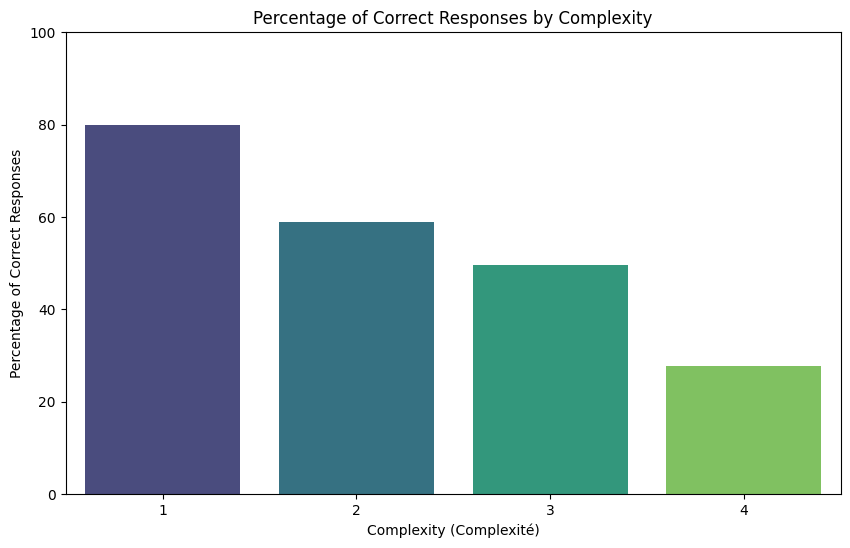

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
# Calculate the percentage of correct responses by 'Complexité'
score_by_complexity = evaluatorDF.groupby('Complexité')['ScoreInt'].mean().reset_index()
score_by_complexity['ScoreInt'] *= 100  # Convert fraction to percentage

# Plotting the results
plt.figure(figsize=(10, 6))
sns.barplot(x='Complexité', y='ScoreInt', data=score_by_complexity, palette='viridis')
plt.title('Percentage of Correct Responses by Complexity')
plt.xlabel('Complexity (Complexité)')
plt.ylabel('Percentage of Correct Responses')
plt.ylim(0, 100)  # Set y-axis to show 0 to 100 for percentage
plt.show()

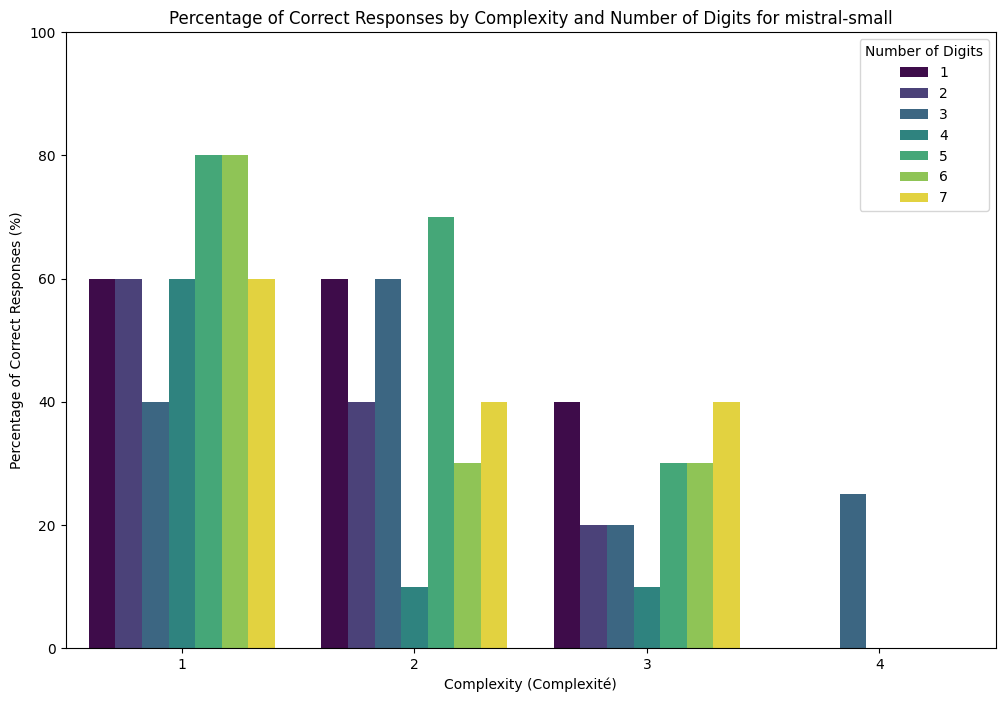

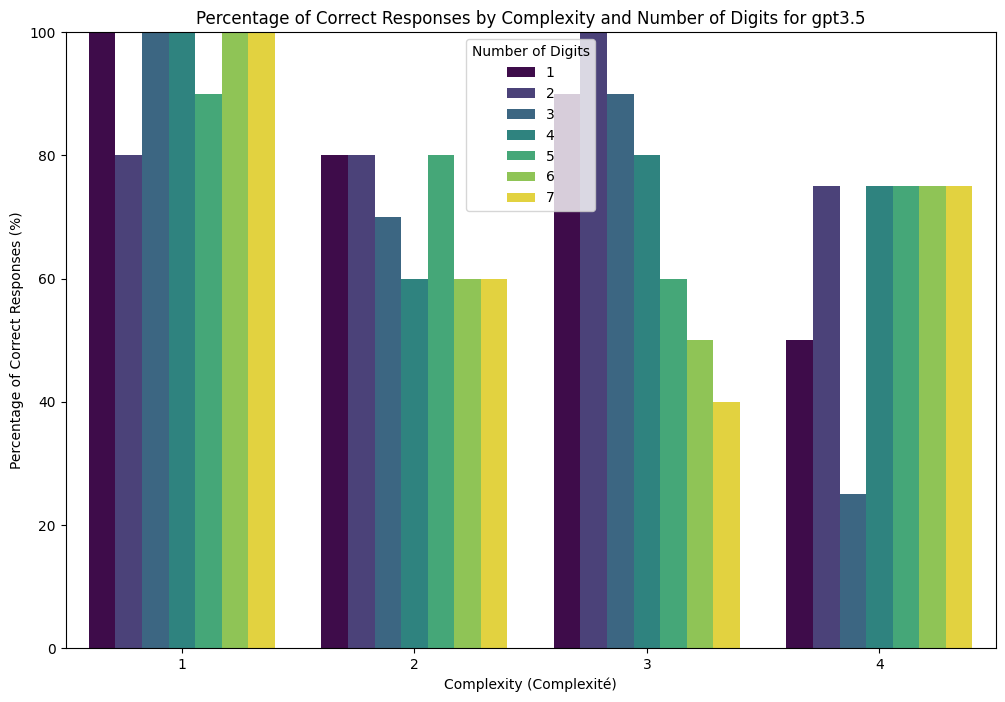

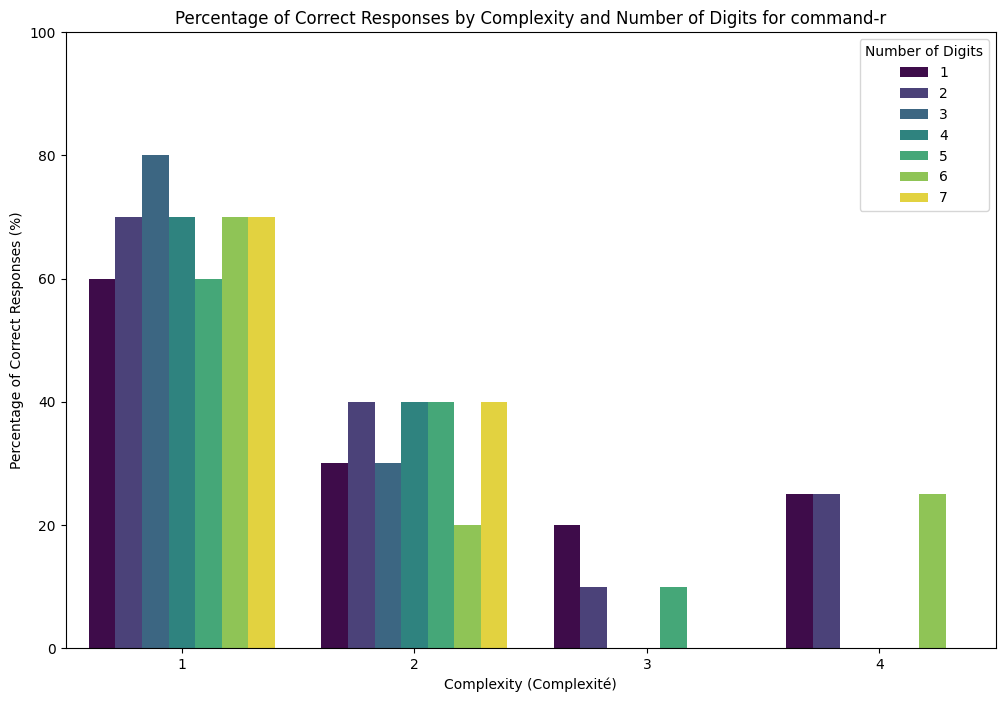

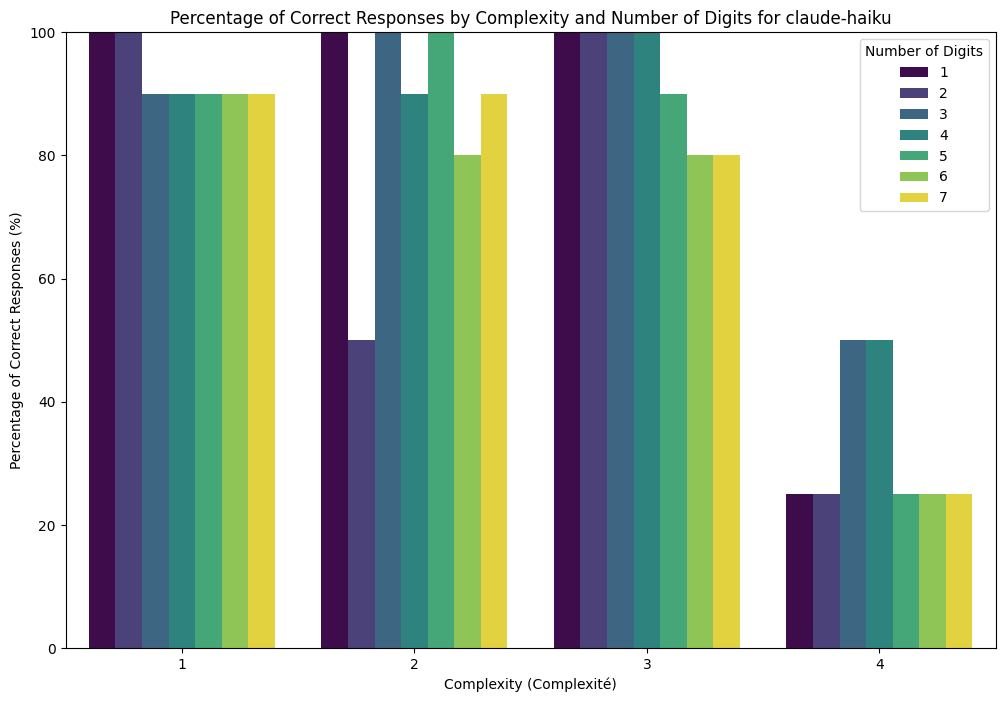

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming evaluatorDF is your DataFrame and it has columns for 'Complexité', 'Nb digits', 'ScoreInt', and 'model'
# Loop through each model and create a separate plot
for model in evaluatorDF['model'].unique():
    # Filter the DataFrame for the current model
    filtered_df = evaluatorDF[evaluatorDF['model'] == model]

    # Calculate the percentage of correct responses by 'Complexité' and 'Nb digits' for the current model
    score_by_complexity_digits = filtered_df.groupby(['Complexité', 'Nb digits'])['ScoreInt'].mean().reset_index()
    score_by_complexity_digits['ScoreInt'] *= 100  # Convert fraction to percentage

    # Plotting the results for the current model
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Complexité', y='ScoreInt', hue='Nb digits', data=score_by_complexity_digits, palette='viridis')
    plt.title(f'Percentage of Correct Responses by Complexity and Number of Digits for {model}')
    plt.xlabel('Complexity (Complexité)')
    plt.ylabel('Percentage of Correct Responses (%)')
    plt.ylim(0, 100)  # Set y-axis to show 0 to 100 for percentage
    plt.legend(title='Number of Digits')
    plt.show()

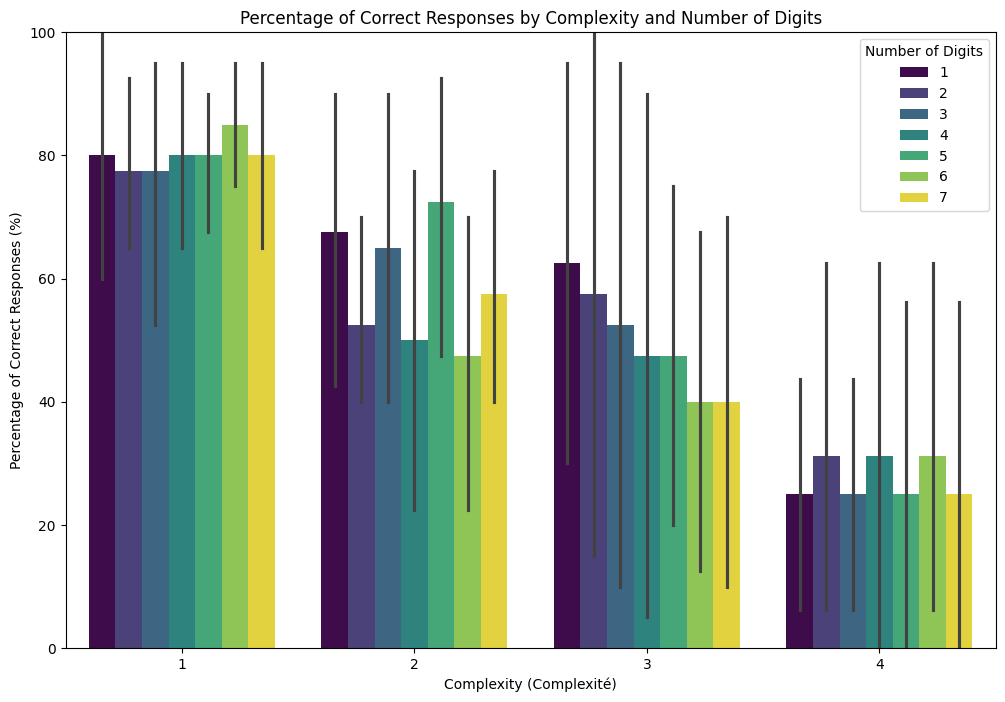

In [30]:
# Assuming evaluatorDF is your DataFrame and it has columns for 'Complexité', 'Nb digits', and 'Score3'
# Calculate the percentage of correct responses by 'Complexité' and 'Nb digits'
score_by_complexity_digits = evaluatorDF.groupby(['Complexité', 'Nb digits'])['ScoreInt'].mean().reset_index()
score_by_complexity_digits['ScoreInt'] *= 100  # Convert fraction to percentage

# Plotting the results
plt.figure(figsize=(12, 8))
sns.barplot(x='Complexité', y='ScoreInt', hue='Nb digits', data=score_by_complexity_digits, palette='viridis')
plt.title('Percentage of Correct Responses by Complexity and Number of Digits')
plt.xlabel('Complexity (Complexité)')
plt.ylabel('Percentage of Correct Responses (%)')
plt.ylim(0, 100)  # Set y-axis to show 0 to 100 for percentage
plt.legend(title='Number of Digits')
plt.show()

#### Score R0

C:\Users\p.beglin\AppData\Local\Temp\ipykernel_18600\2209384277.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Complexité', y='ScoreR0', data=score_by_complexity, palette='viridis')


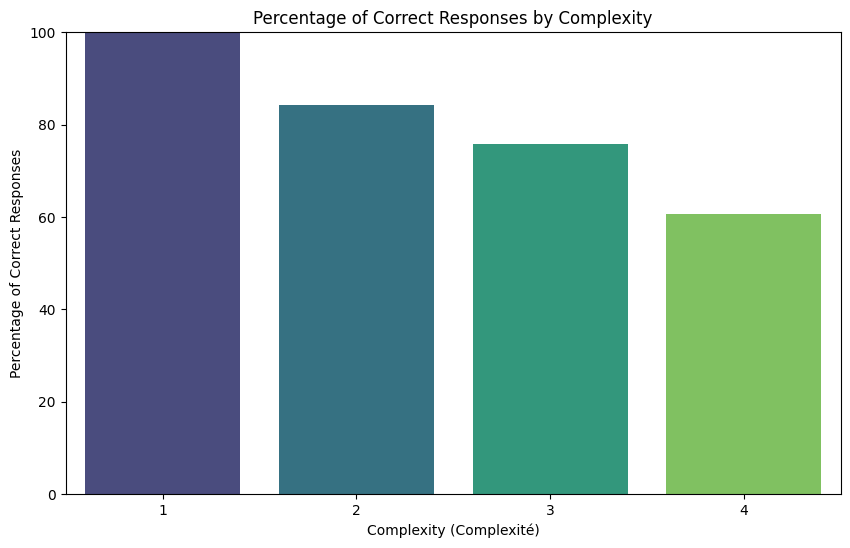

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
# Calculate the percentage of correct responses by 'Complexité'
score_by_complexity = evaluatorDF.groupby('Complexité')['ScoreR0'].mean().reset_index()
score_by_complexity['ScoreR0'] *= 100  # Convert fraction to percentage

# Plotting the results
plt.figure(figsize=(10, 6))
sns.barplot(x='Complexité', y='ScoreR0', data=score_by_complexity, palette='viridis')
plt.title('Percentage of Correct Responses by Complexity')
plt.xlabel('Complexity (Complexité)')
plt.ylabel('Percentage of Correct Responses')
plt.ylim(0, 100)  # Set y-axis to show 0 to 100 for percentage
plt.show()

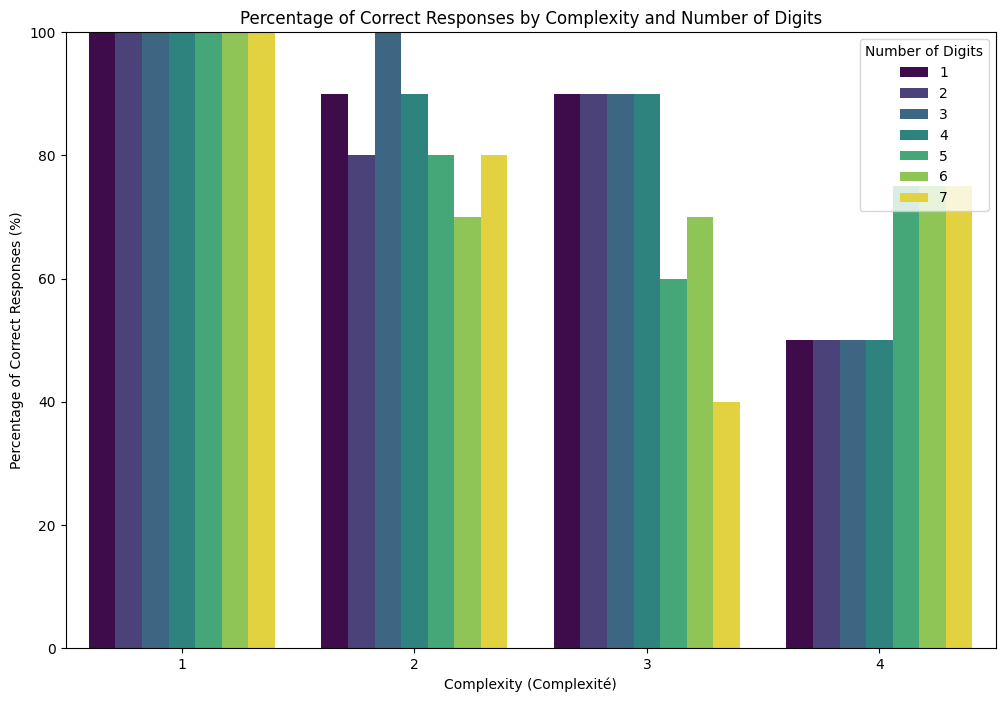

In [24]:
# Assuming evaluatorDF is your DataFrame and it has columns for 'Complexité', 'Nb digits', and 'Score3'
# Calculate the percentage of correct responses by 'Complexité' and 'Nb digits'
score_by_complexity_digits = evaluatorDF.groupby(['Complexité', 'Nb digits'])['ScoreR0'].mean().reset_index()
score_by_complexity_digits['ScoreR0'] *= 100  # Convert fraction to percentage

# Plotting the results
plt.figure(figsize=(12, 8))
sns.barplot(x='Complexité', y='ScoreR0', hue='Nb digits', data=score_by_complexity_digits, palette='viridis')
plt.title('Percentage of Correct Responses by Complexity and Number of Digits')
plt.xlabel('Complexity (Complexité)')
plt.ylabel('Percentage of Correct Responses (%)')
plt.ylim(0, 100)  # Set y-axis to show 0 to 100 for percentage
plt.legend(title='Number of Digits')
plt.show()